# Autoencoder
Autoencoders are used to learn efficient data codings in an unsupervised manner. The aim is to learn a representation (encoding) for a set of data, typically for the purpose of dimentionality reduction. The concept has become more widely used for generative models of data. Some of most powerful algorithms recently have involved sparse autoencoders stacked inside of deep neural networks.

We will try to create following autoencoders:
- a simple autoencoder based on a fully connected layer
- a sparse autoencoder
- a deep fully-connected autoencoder
- a deep convolutional autoencoder
- an image denoising model
- a sequence-to-sequence autoencoder
- a variational autoenoder

Autoencoders are data compression algorithms which are data-specific, lossy and learned automatically from examples. The compression and depcompression functions are implemented with neural networks.
- Data specific: They will only be able to compress data similar to what they have been trained on. Unlike normal compression algorithms, they are not very generic about the data they hold. For example, an autoencoder trained on pictures of faces would do a poor job of compressing pictures of trees because the features it learned are face-specific.
- Lossy: The decompressed outputs will be degraded compared to original inputs
- Auto learned: It's easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require new engineering, just appropriate training data

We need 3 things to build autoencodere: an encoding function, a decoding function and a distance function between the amount of information loss between the compressed representation of data and the decompressed representation (loss function).

**Are they good at data compression?**
Not really. The fact that they are are data-specific makes the generally impractival for real-world data compression problems. Making them genreal requires a lot of training data. Future advances might change this.

**What are they good for?**
Data denoising and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

**What's the big deal with autoencoders?**
Absolutely fascinating for newcomers. They have long beein throught to be a potential avenue for the learning of useful representations without the need for labels. But since they are self-supervised, it's not a true unsupervised learning technique. 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [3]:
# we will start simple with a single fully-connected neural layer as encoder and decoder
# this is the siez of our encoded representations
ENCODING_DIM = 32

# input placeholder
input_img = tf.keras.layers.Input(shape=(784,))

# this is the encoded representation of the input
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

# this is the loss reconstruction of the input
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its recommendation
autoencoder = tf.keras.models.Model(input_img, decoded)

In [4]:
# let's also create a seprate encoder model
# this mode maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)

In [5]:
# as well as decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

In [6]:
# Now let's train our autoencoder to reconstruct MNIST digits
# first we will configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
# let's prepare our input data. We are using MNIST digits and we are disregrading the labels (since we are only interested in encoding/decoding the input images)
# load the data
(x_train, _), (x_test, _) = load_data('/home/gf/.keras/datasets/mnist.npz')

In [9]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
# now let's train our autoencoder for 50 epochs
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.3604 - val_loss: 0.2704
Epoch 2/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.2621 - val_loss: 0.2496
Epoch 3/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2382 - val_loss: 0.2252
Epoch 4/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2176 - val_loss: 0.2079
Epoch 5/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2031 - val_loss: 0.1958
Epoch 6/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1925 - val_loss: 0.1867
Epoch 7/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1842 - val_loss: 0.1792
Epoch 8/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.1774 - val_loss: 0.1731
Epoch 9/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1717 - val_loss: 0.1678
Epoch

In [11]:
# after 50 epochs the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will be using Matplotlib
# encode and decode some digits
# note that we take them from the "test" set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

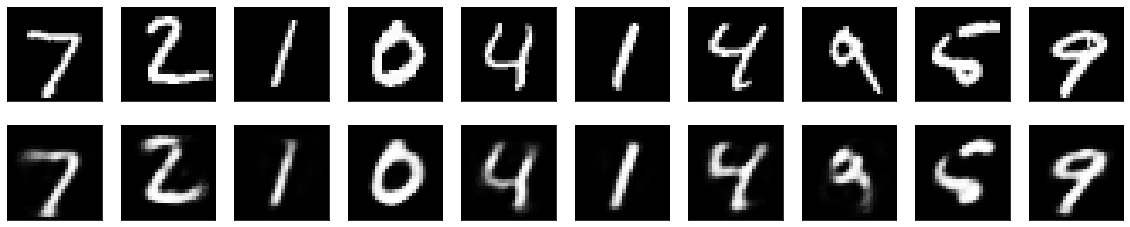

In [12]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Adding a sparsity constraint on the encoded representations
The representations were only constrained by the size of the hidden layer (32). In such a situation, the hidden layer is learning an approximation of PCA. But another way to constain the representation to be compact is to add a sparsity constraint on the activity of the hiddne representations, so fewer units would "fire" at a given time. We can do this by adding `activity_regularizer` to our `Dense` layer.

In [13]:
ENCODING_DIM = 32

input_img = tf.keras.layers.Input(shape=(784,))

# add a dense layer with L1 activity regularizer
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# now let's train this for 100 epochs (with added regularization, the model is less likely to overfit and can be trained longer). The model ends with a train loss of 0.11 and test loss of 0.10. The difference is mostly due to the regularization term being added to the loss during training
autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.6736 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 4s 58us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.4531 - val_loss: 0.4

60000/60000 [==============================] - 3s 58us/step - loss: 0.2828 - val_loss: 0.2826
Epoch 78/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2825 - val_loss: 0.2823
Epoch 79/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2822 - val_loss: 0.2820
Epoch 80/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.2819 - val_loss: 0.2817
Epoch 81/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2816 - val_loss: 0.2814
Epoch 82/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.2813 - val_loss: 0.2812
Epoch 83/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2810 - val_loss: 0.2809
Epoch 84/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2808 - val_loss: 0.2806
Epoch 85/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.2805 - val_loss: 0.2804
Epoch 86/100
60000/60000 [========================

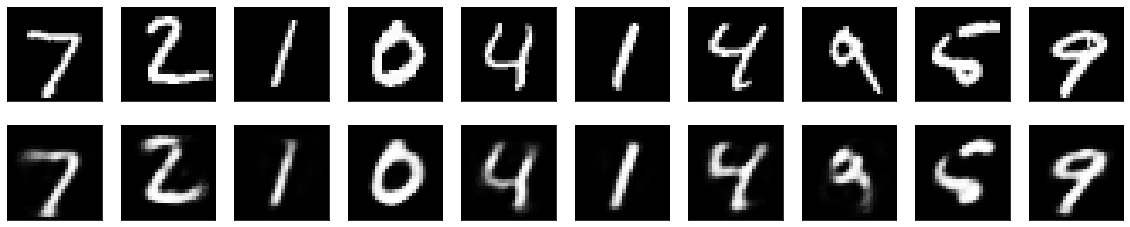

In [14]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

The images look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. `encoded_imgs.mean()` yields a value of 3.33 over 10,000 test images. whereas with previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

**Deep autoencoder**
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers.

In [15]:
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

In [16]:
# let's try this
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.3332 - val_loss: 0.2614
Epoch 2/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2516 - val_loss: 0.2416
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2333 - val_loss: 0.2243
Epoch 4/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2187 - val_loss: 0.2090
Epoch 5/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.2037 - val_loss: 0.1963
Epoch 6/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.1913 - val_loss: 0.1874
Epoch 7/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1822 - val_loss: 0.1779
Epoch 8/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.1762 - val_loss: 0.1727
Epoch 9/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.1719 - val_loss: 0.1679
Epoch

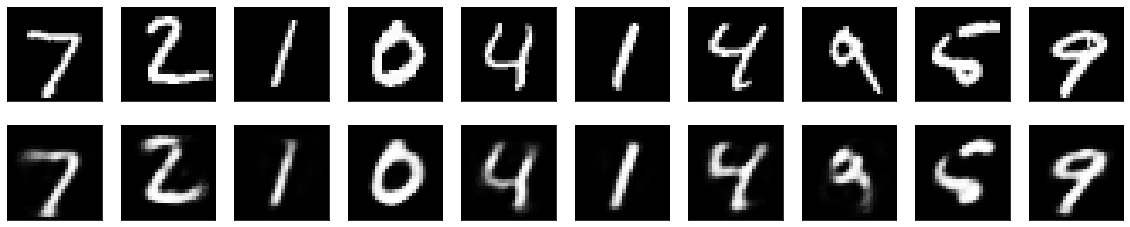

In [17]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (CNNs) as encoders and decoders. In practical settings, autoencoders for images are always convolutional since they perform much better.

This encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.

In [18]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) and we will just normalize pixel values between 0 and 1
(x_train, _), (x_test, _) = load_data('/home/gf/.keras/datasets/mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [21]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2100 - val_loss: 0.1629
Epoch 2/10
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1536 - val_loss: 0.1416
Epoch 3/10
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1389 - val_loss: 0.1331
Epoch 4/10
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1301 - val_loss: 0.1259
Epoch 5/10
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1251 - val_loss: 0.1200
Epoch 6/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1212 - val_loss: 0.1199
Epoch 7/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1184 - val_loss: 0.1164
Epoch 8/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1163 - val_loss: 0.1187
Epoch 9/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1141 - val_loss: 0.1111
Epoch

The model converges to a loss of 0.098, significantly better than previous model which is in large part due to the higher entropic capacity of the encoded representations (128 vs 32 previously).

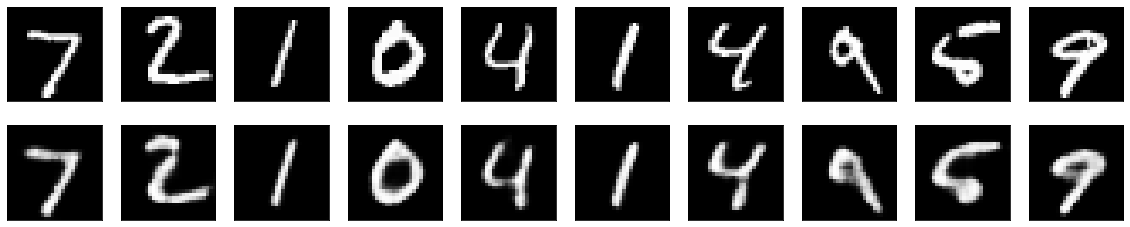

In [22]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# # we can also look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images
# n = 10
# plt.figure(figsize=(20, 8))
# for i in range(n):
#     ax = plt.subplot(1, n, i + 1)
#     plt.imshow(encoded_imgs[i + 1].reshape(4, 4 * 8).T)
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

Application to image denoising

Let's put our convolutional autoencoder to work on an image denoising problem. We will train the autoencoder to map noisy digits images to clean digit images. We will generate synthetic noisy digits by applying a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
(x_train, _), (x_test, _) = load_data('../input/mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Can our autoencoder learn to recover the original digits. We will use a slightly different model with more filters per layer
input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
# let's train for 100 epochs
autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test), callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

In [ ]:
# Let's see how it did
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Sequence-to-sequence autoencoder

If your inputs are sequences, rather than vectors of 2D images, then you may want your encoder and decoder to capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vecotr that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

Following is a code example which you can implement for your dataset.

In [ ]:
# inputs = tf.keras.layers.Input(shape=(timesteps, input_dim))
# encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

# decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
# decoded = tf.keras.layers.LSTM(input_dmi, return_sequences=True)(decoded)

# sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
# encoder = tf.keras.models.Model(inputs, encoded)

Variational Autoencoder (VAE)

Variational autoencoders are a slightly more modern and interesting take on autoencoding. It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you an generate new input data samples. VAE is a generative model.

**How does it work?**
First, an encoder network turns the input samples `x` into two parameters in a latent space, which we will note as `z_mean` and `z_log_sigma`. Then we randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via `z = z_mean + exp(x_log_sigma) * epsilon`, where `epsilon` is a random normal tensor. Finally, a deocded network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstriction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regulaization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

In [ ]:
# helper functions

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon
    
    
def plot_results(models, data, batch_size=128, model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data('../input/mnist.npz')

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# tf.keras.utils.plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name='vae_mlp')

models = (encoder, decoder)
data = (x_test, y_test)
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# tf.keras.utils.plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

In [ ]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.save_weights('vae_mlp.mnist.h5')

In [ ]:
# Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.
plot_results(models, data, batch_size=batch_size, model_name='vae_mlp')

That's it for Autoecoders. Generative Autoadverserial Networks work much better than Autoencoders. They also generalize really well over a large problem domain. Check out other kernels for some examples of GANs.